# Notebook 2

## This notebook includes more recent work after performing some preliminary scratchwork (in 'MTA-brian') and performing Challenge 1.

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import seaborn as sns

In [74]:
# Import local CSV files and change name of EXITS column

df_dec19 = pd.read_csv('december_turnstiles.csv')
df_dec19 = df_dec19.rename(columns={'EXITS                                                               ':'EXITS'})
df_mar20 = pd.read_csv('march_turnstiles.csv')
df_mar20 = df_mar20.rename(columns={'EXITS                                                               ':'EXITS'})
df_june20 = pd.read_csv('june_turnstiles.csv')
df_june20 = df_june20.rename(columns={'EXITS                                                               ':'EXITS'})

In [25]:
# Functions to organize data by foot traffic, turnstiles, and traffic (credit: Lauren Fields)
"""
This is the original function

def combinedTraffic(dataframe):
    dataframe["FOOTTRAFFIC"] = dataframe["ENTRIES"] + dataframe["EXITS"]
    
def turnstileColumn(dataframe):
    '''
    Takes an MTA dataframe & creates a new column
    Where there's an index number for each Turn Stile in frame.
    '''
    eachTS = dataframe.groupby(["C/A", "UNIT", "SCP", "STATION"])[['FOOTTRAFFIC']].sum()
    howMany = eachTS.shape[0]
    eachTS['TURNSTILE'] = range(1,(howMany + 1))
    del eachTS["FOOTTRAFFIC"]
    dataframe = pd.merge(dataframe, eachTS,  how='left',
                         left_on=['C/A','UNIT','SCP', 'STATION'],
                         right_on = ['C/A','UNIT','SCP', 'STATION'])    
    return dataframe

def trafficFix(dataframe):
    dataframe['FOOTTRAFFIC'] = dataframe.groupby('TURNSTILE')['FOOTTRAFFIC'].diff().fillna(method='backfill')
    # dataframe.groupby('TURNSTILE')['FOOTTRAFFIC'].transform('mean')
    dataframe['FOOTTRAFFIC'] = dataframe['FOOTTRAFFIC'].astype(int)
    return dataframe
    
"""

def betterColumns(dataframe):
    dataframe['TIMESTAMP'] = pd.to_datetime(dataframe['DATE'] + ' ' + dataframe['TIME'])
    dataframe.columns = dataframe.columns.str.rstrip()
    dataframe['FOOTTRAFFIC'] = dataframe['ENTRIES'] + dataframe['EXITS']
    return dataframe

def turnstileColumn(dataframe):
    '''
    Takes an MTA dataframe & creates a new column
    Where there's an index number for each Turn Stile in frame.
    '''
    eachTS = dataframe.groupby(["C/A", "UNIT", "SCP", "STATION"])[['ENTRIES']].count()
    del eachTS['ENTRIES']
    howMany = len(eachTS)
    eachTS['TURNSTILE'] = range(1,(howMany + 1))
    dataframe = pd.merge(dataframe, eachTS,  how='left',
                         left_on=['C/A','UNIT','SCP', 'STATION'],
                         right_on = ['C/A','UNIT','SCP', 'STATION'])    
    return dataframe

def trafficFix(dataframe):
    dataframe['FOOTTRAFFIC'] = dataframe.groupby('TURNSTILE')['FOOTTRAFFIC'].diff().fillna(method='backfill')
    dataframe['FOOTTRAFFIC'] = dataframe['FOOTTRAFFIC'].astype(int)
    return dataframe

In [79]:
# Create a new FOOTTRAFFIC column for each data set
"""
betterColumns(df_dec19)
betterColumns(df_mar20)
betterColumns(df_june20)

df_dec19
"""

'\nbetterColumns(df_dec19)\nbetterColumns(df_mar20)\nbetterColumns(df_june20)\n\ndf_dec19\n'

In [78]:
#turnstileColumn(df_dec19)
#df_dec19

In [77]:
#trafficFix(df_dec19)
#df_dec19

In [24]:
def get_daily_counts(row, max_counter):
    """
    This function is used for maxFoottraffic.
    """
    counter = row["FOOTTRAFFIC"] - row["PREV_FOOTTRAFFIC"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row["FOOTTRAFFIC"], row["PREV_FOOTTRAFFIC"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def maxFoottraffic(dataframe):
    """
    This function calls get_daily_counts so that function must be entered prior.
    The purpose of this function is check the top 10 highly trafficked stations,
    depending on what dataframe is entered (June, July, December, etc.)
    """
    daily_counts_df = dataframe.groupby(["C/A","UNIT","SCP","STATION","DATE"], as_index=False)["FOOTTRAFFIC"].first()

    daily_counts_df[["PREV_DATE", "PREV_FOOTTRAFFIC"]] = (daily_counts_df
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "FOOTTRAFFIC"]
                                                       .apply(lambda grp: grp.shift(1)))

    daily_counts_df.dropna(subset=["PREV_DATE"], inplace=True)
    
    daily_counts_df["DAILY_FOOTTRAFFIC"] = daily_counts_df.apply(get_daily_counts, axis=1, max_counter=100000)
  
    station_counts_df = daily_counts_df.groupby(["STATION"], as_index=False)["DAILY_FOOTTRAFFIC"].sum()
    
    return station_counts_df.sort_values('DAILY_FOOTTRAFFIC', ascending=False)
    

df_dec19_foottraffic = maxFoottraffic(df_dec19)
df_mar20_foottraffic = maxFoottraffic(df_mar20)
df_june20_foottraffic = maxFoottraffic(df_june20)

df_dec19_foottraffic

/Users/brian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,STATION,DAILY_FOOTTRAFFIC
61,34 ST-PENN STA,5974839.0
233,GRD CNTRL-42 ST,5069801.0
59,34 ST-HERALD SQ,4431511.0
46,23 ST,3821356.0
14,14 ST-UNION SQ,3636247.0
...,...,...
148,BEACH 98 ST,15515.0
123,ASTORIA BLVD,13283.0
353,TOMPKINSVILLE,10946.0
141,BEACH 105 ST,7954.0


In [49]:
# Next step is to take sum of three data sets and take top 10 as a figure.

total_foottraffic = df_dec19_foottraffic.set_index('STATION').\
    join(df_june20_foottraffic.set_index('STATION'), lsuffix = '_DEC').\
    join(df_mar20_foottraffic.set_index('STATION'), lsuffix = '_JUNE', rsuffix = '_MAR')

total_foottraffic['DAILY_FOOTTRAFFIC_TOTAL'] = total_foottraffic['DAILY_FOOTTRAFFIC_DEC'] +\
    total_foottraffic['DAILY_FOOTTRAFFIC_JUNE'] + total_foottraffic['DAILY_FOOTTRAFFIC_MAR']

total_foottraffic = total_foottraffic.sort_values('DAILY_FOOTTRAFFIC_TOTAL', ascending=False).head(10).reset_index()

total_foottraffic

,STATION,DAILY_FOOTTRAFFIC_DEC,DAILY_FOOTTRAFFIC_JUNE,DAILY_FOOTTRAFFIC_MAR,DAILY_FOOTTRAFFIC_TOTAL
0,34 ST-PENN STA,5974839.0,679963.0,1993386.0,8648188.0
1,GRD CNTRL-42 ST,5069801.0,468176.0,1635237.0,7173214.0
2,34 ST-HERALD SQ,4431511.0,487667.0,1509835.0,6429013.0
3,23 ST,3821356.0,416987.0,1318951.0,5557294.0
4,14 ST-UNION SQ,3636247.0,475299.0,1360009.0,5471555.0
5,42 ST-PORT AUTH,3314623.0,489845.0,1257710.0,5062178.0
6,TIMES SQ-42 ST,3460186.0,351448.0,1218547.0,5030181.0
7,FULTON ST,3244544.0,400904.0,1183924.0,4829372.0
8,86 ST,3041787.0,517185.0,1232643.0,4791615.0
9,125 ST,2530981.0,657048.0,1384089.0,4572118.0


Text(0.5, 1.0, 'Top 10 Stations')

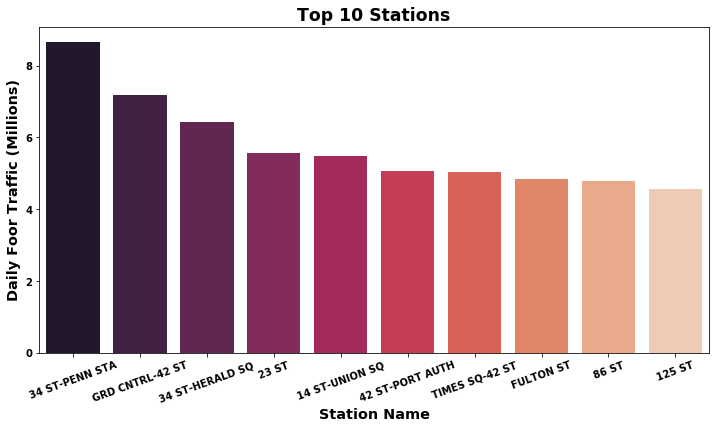

In [72]:
plt.figure(figsize=[12, 6])

ax1 = sns.barplot(x = 'STATION', y = total_foottraffic['DAILY_FOOTTRAFFIC_TOTAL']/1e6,
                  data=total_foottraffic,
                  palette="rocket",)
plt.xticks(rotation=20)
ax1.set_xlabel('Station Name', fontdict=font, fontsize='x-large')
ax1.set_ylabel('Daily Foor Traffic (Millions)', fontdict=font, fontsize='x-large')
plt.title('Top 10 Stations', fontdict=font, fontsize='xx-large')

In [84]:
no_good_dec = df_dec19[df_dec19['FOOTTRAFFIC']< 0]
no_good_dec

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,FOOTTRAFFIC,TURNSTILE


In [94]:
no_good_june = df_june20[df_june20['FOOTTRAFFIC'] < 0]
no_good_june

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,FOOTTRAFFIC,TURNSTILE


In [95]:
no_good_mar = df_mar20[df_mar20['FOOTTRAFFIC'] < 0]
no_good_mar

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,FOOTTRAFFIC,TURNSTILE
